# Выражение эмоций с помощью вариационного автоэнкодера

Натренируем вариационный автоэнкодер "рисовать" портрет человека с четко заданной степенью выражения эмоций и позицией камеры относительно человека.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Скачиваем данные: датасет "Frey faces", любезно предоставленный Computer Science Department NYU. Датасет состоит из фотографий одного и того же человека с разных ракурсов и с разными эмоциями на лице.

In [4]:
import os
from urllib.request import urlopen, URLError, HTTPError
from scipy.io import loadmat


def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file", url)

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")
        
    #handle errors
    except HTTPError:
        print("HTTP Error:", e.code, url)
    except URLError:
        print("URL Error:", e.reason, url)
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists.", data_filename)
    
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Data file %s exists. frey_rawface.mat


In [5]:
len(ff)

1965

Всего 1965 фотографий. Посмотрим на них:

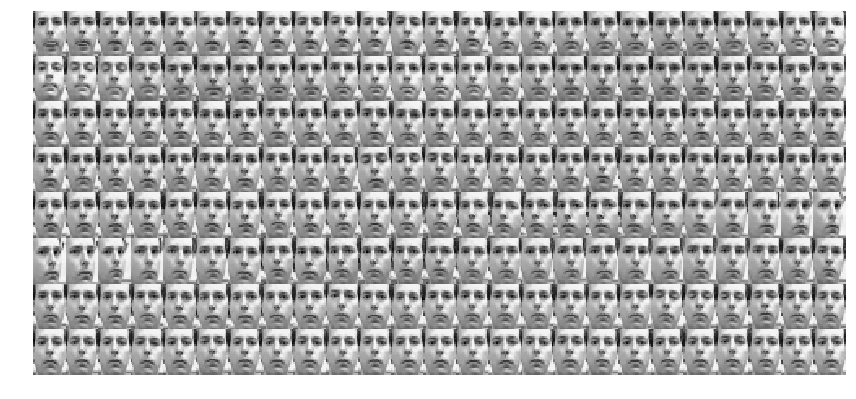

In [24]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=200, n_cols=25)

Делим выборку на train и test:

In [6]:
np.random.seed(42)
n_pixels = img_rows * img_cols
X_train = ff[:1800]
X_val = ff[1800:1900]
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), n_pixels))
X_val = X_val.reshape((len(X_val), n_pixels))

Выбираем архитектуру энкодера. Пусть она будет вот такой:

In [8]:
from keras import backend
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy

intermediate_dim = 256
latent_dim = 2
batch_size = 100

nb_epoch = 100
noise_std = .01
x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = backend.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=noise_std)
    epsilon *= backend.exp(.5 * z_log_var)
    epsilon += z_mean
    return epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

Архитектура декодера:

In [10]:
decoder_h1 = Dense(intermediate_dim, activation="relu")
decoder_h2 = Dense(n_pixels, activation="sigmoid")
z_decoded = decoder_h1(z)
x_decoded = decoder_h2(z_decoded)

Итоговый автоэнкодер будет выглядеть вот так:

In [11]:
vae = Model(input=x, output=x_decoded)
from keras.utils import vis_utils as vizu
vizu.plot_model(vae, "ff.png", show_layer_names=False, show_shapes=True)

/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


<img src='ff.png'>

Выписываем функционал, который автоэнкодер будет минимизировать:

In [12]:
# Objective function minimized by autoencoder
def vae_objective(x, x_decoded):
    loss = binary_crossentropy(x, x_decoded)
    kl_regu = -.5 * backend.sum(1. + z_log_var - backend.square(
        z_mean) - backend.exp(z_log_var), axis=-1)
    return loss + kl_regu

Компилируем граф:

In [13]:
# Compile the autoencoder computation graph
vae.compile(optimizer="adam", loss=vae_objective)

Обучаем автоэнкодер (или подгружаем обученную ранее модель):

In [14]:
import os
weights_file = "ff_%d_latent.hdf5" % latent_dim
if os.path.isfile(weights_file):
    vae.load_weights(weights_file)
else:
    from keras.callbacks import History
    hist_cb = History()
    vae.fit(X_train, X_train, shuffle=True, nb_epoch=nb_epoch, batch_size=batch_size,
            callbacks=[hist_cb], validation_data=(X_val, X_val))
    vae.save_weights(weights_file)
    
    # plot convergence curves to show off
    plt.plot(hist_cb.history["loss"], label="training")
    plt.plot(hist_cb.history["val_loss"], label="validation")
    plt.grid("on")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="best")

In [15]:
encoder = Model(input=x, output=z_mean)

/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [16]:
decoder_input = Input(shape=(latent_dim,))
h_decoded = decoder_h1(decoder_input)
x_decoded = decoder_h2(h_decoded)
generator = Model(input=decoder_input, output=x_decoded)

/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


Посмотри на многообразие лиц. Отметим, что каждая размерность в скрытом представлении $z$ кодирует социально-значимую часть (например, юмор, эмоцию, позу, мимику). Попробуем рисовать портреты с разной степенью юмора или разным углом обзора:

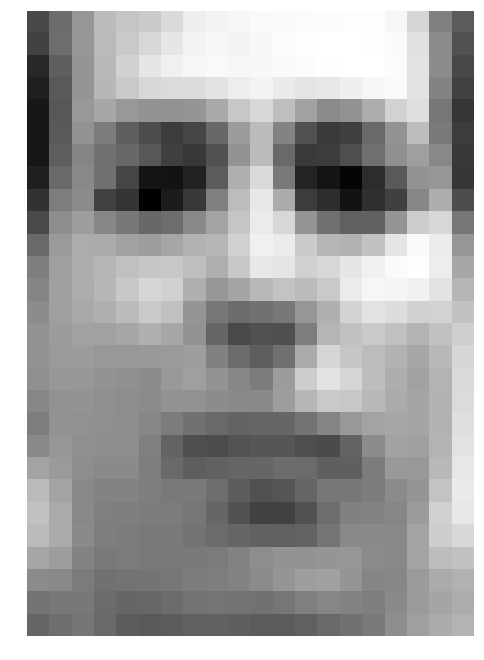

In [21]:
from ipywidgets import FloatSlider, interact

# we will sample points within given standard deviations
humour = FloatSlider(min=-15, max=15, step=3, value=0)
pose = FloatSlider(min=-15, max=15, step=3, value=0)

@interact(pose=pose, humour=humour)
def do_thumb(humour, pose):
    z_sample = np.array([[humour, pose]]) * noise_std
    x_decoded = generator.predict(z_sample)
    face = x_decoded[0].reshape(img_rows, img_cols)
    plt.figure(figsize=(11.5, 11.5))
    ax = plt.subplot(111)
    ax.imshow(face)
    plt.axis("off")

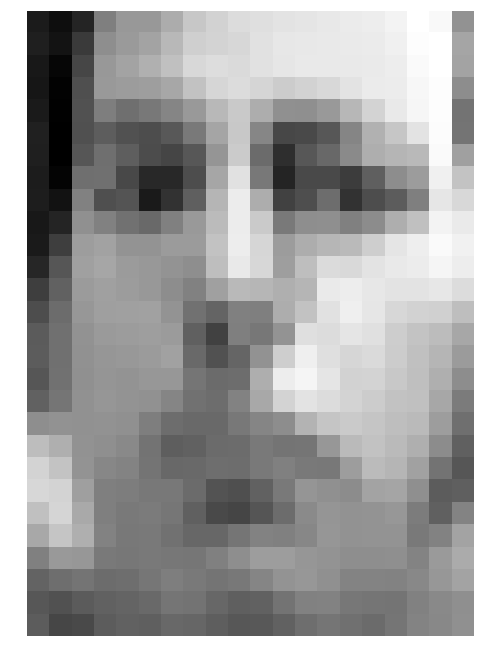

In [25]:
do_thumb(-15, -15)

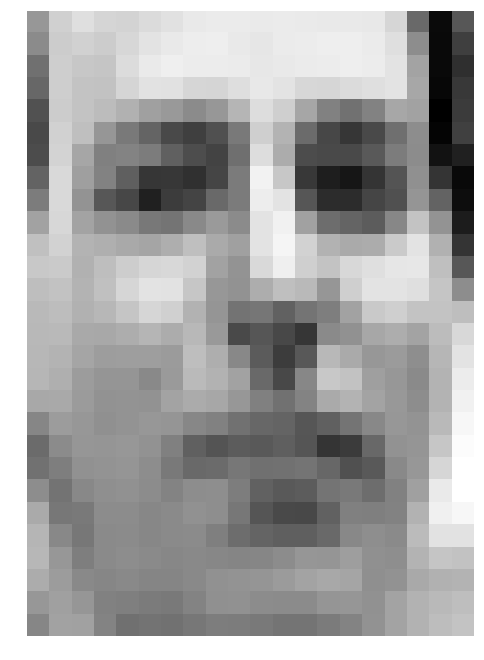

In [27]:
do_thumb(15, 15)